# Implementation of the Gibbs sampler from the section 3

On creer notre state space modele lorsque conditionnellement à z et zeta. Deplus ce state space modèle est défini unique pour un actif car conditionnelement à z et zeta nos actif sont independant.

On ne pourra pas directement utilisé le mcmc.ParticleGibbs de particules car l'un des principales aventage de l'augmented Gibbs est que conditionnelement au facteur on peut faire chaque actif est indépendant

In [7]:
import numpy as np
from scipy import stats, linalg
import particles
from particles import state_space_models as ssm
from particles import distributions as dists
import matplotlib.pyplot as plt
from tqdm import tqdm # Pour la barre de progression (optionnel mais recommandé)
from particles import smoothing
from particles.mcmc import CSMC # Indispensable pour le Particle Gibbs
from particles import state_space_models as ssm
from particles import distributions as dists
import matplotlib.pyplot as plt
import numpy as np
import numpy as np
from scipy import linalg
import particles
from particles import distributions
from scipy import stats
from particles import mcmc

In [8]:
class IdentifiedLoadingSSM(ssm.StateSpaceModel):
    """
    Modèle espace d'état avec correction MvNormal pour éviter les erreurs de broadcasting.
    """
    def __init__(self, row_idx, p_factors, mu, phi, sigma_eta, z, zeta, data_x):
        self.i = row_idx
        self.p = p_factors
        # Dimension effective
        self.dim_state = min(row_idx + 1, p_factors)
        
        # Paramètres
        self.mu = mu[:self.dim_state]
        self.phi = phi[:self.dim_state]
        self.sigma_eta = sigma_eta[:self.dim_state]
        
        self.z = z       
        self.zeta = zeta 
        self.data_x = data_x 

    def PX0(self):
        """Distribution initiale : MvNormal"""
        # Variance stationnaire
        var_0 = self.sigma_eta**2 / (1 - self.phi**2)
        # On crée une matrice de covariance diagonale (dim_state, dim_state)
        cov_0 = np.diag(var_0)
        
        # Utilisation explicite de MvNormal pour gérer les vecteurs correctement
        return distributions.MvNormal(loc=self.mu, cov=cov_0)
    
    def PX0(self):
        """Distribution initiale avec variance gonflée (Diffuse Prior)"""
        # Le texte dit : N(mu, Sigma * 100)
        # Ici self.sigma_eta correspond au Sigma du texte (variance du choc)
        
        # Option A: Interprétation stricte (Sigma * 100)
        var_0 = self.sigma_eta**2 * 100.0
        
        # Option B: Variance stationnaire * 100 (souvent utilisé aussi)
        # var_0 = (self.sigma_eta**2 / (1 - self.phi**2)) * 100.0
        
        # L'article semble suggérer l'Option A ou simplement une grande variance.
        # Utilisons l'Option A qui est plus simple et "diffuse".
        
        cov_0 = np.diag(var_0)
        return distributions.MvNormal(loc=self.mu, cov=cov_0)

    def PX(self, t, xp):
        """Transition : MvNormal"""
        # xp est (N, dim_state). mean sera (N, dim_state)
        mean = self.mu + self.phi * (xp - self.mu)
        
        # Covariance du bruit de transition
        cov_eta = np.diag(self.sigma_eta**2)
        
        return distributions.MvNormal(loc=mean, cov=cov_eta)

    def PY(self, t, xp, x):
        """Vraisemblance"""
        # x est de forme (N, dim_state)
        N = x.shape[0]
        
        # 1. Reconstitution
        real_loadings = np.zeros((N, self.p)) 
        real_loadings[:, :self.dim_state] = x
        
        # 2. Transformation Log -> Exp
        if self.i < self.p:
            real_loadings[:, self.i] = np.exp(x[:, self.i])
            
        # 3. Paramètres
        z_t = self.z[t]
        factor_comp = np.dot(real_loadings, z_t)
        
        lam_sq = np.sum(real_loadings**2, axis=1)
        scaling = np.sqrt(1.0 + lam_sq)
        sigma_eps = 1.0 / scaling
        
        zeta_sqrt = np.sqrt(self.zeta[t])
        
        mean_obs = zeta_sqrt * (factor_comp / scaling)
        scale_obs = zeta_sqrt * sigma_eps
        
        # Retourne l'objet Distribution (nécessaire pour particles)
        return distributions.Normal(loc=mean_obs, scale=scale_obs)


In [ ]:
class FactorCopulaSampler:
    def __init__(self, data, n_factors):
        self.data = data
        self.T, self.n = data.shape
        self.p = n_factors
        
        # --- 1. Initialisation des Paramètres ---
        self.theta = {
            'mu': np.random.normal(0.4, 0.5, size=(self.n, self.p)),
            'phi': np.random.uniform(0.5, 0.9, size=(self.n, self.p)),
            'sigma': np.ones((self.n, self.p)) * 0.1
        }
        
        # --- 2. Variables Latentes ---
        self.z = np.random.normal(size=(self.T, self.p))
        self.zeta = np.ones((self.T, self.n))
        
        # Stockage des états: (T, n, p)
        self.latent_states = np.zeros((self.T, self.n, self.p))
        self.lambdas = np.zeros((self.T, self.n, self.p))
        
        # Initialisation (Diagonale non nulle pour éviter log(0))
        for i in range(self.p):
            self.lambdas[:, i, i] = 0.5
            self.latent_states[:, i, i] = np.log(0.5)
            
        # Flag pour savoir si c'est la toute première itération (SMC vs CSMC)
        self.first_iter = True




    def update_zeta(self):
        """
        Step: Mise à jour des variables de mélange zeta_t (Cas G=1).
        Dans l'article, zeta_t suit une loi Inverse Gamma.
        On utilise la propriété : Si X ~ Gamma(a, b), alors 1/X ~ InvGamma(a, b).
        """
        T, N = self.T, self.n
        
        # 1. Paramètre de Forme (Shape) alpha
        # Formule : (nu + N) / 2
        # C'est la même valeur pour tous les temps t
        alpha_post = (self.nu + N) / 2.0
        
        # Nouveau vecteur pour stocker les zeta_t
        new_zetas = np.zeros((T, 1))
        
        for t in range(T):
            # A. Récupération des données à l'instant t
            x_t = self.data[t]       # Rendements observés (N,)
            z_t = self.z[t]          # Facteurs latents (p,)
            lam_t = self.lambdas[t]  # Chargements (N, p)
            
            # Note : self.zeta est la variable de mélange globale (scalaire par temps t)
            # Dans le modèle G=1, elle est commune à tous les actifs à l'instant t.
            # (Si vous aviez des variances idiosyncratiques sigma_eps distinctes, 
            # elles devraient être gérées ici, mais simplifions selon G=1 standard).

            # B. Calcul de la distance de Mahalanobis (ou somme des carrés) d_t
            # Modèle : x_t = lambda_t * z_t + epsilon_t
            
            # Moyenne théorique
            mean_t = np.dot(lam_t, z_t)
            
            # Résidus (epsilon_t)
            resid = x_t - mean_t
            
            # Terme quadratique d_t = resid' * Sigma^-1 * resid
            # Ici, on suppose Sigma = Identité conditionnellement (ou diagonale fixe).
            # Si vous avez un paramètre 'sigma' idiosyncratique distinct, divisez par lui.
            d_t = np.sum(resid**2)
            
            # C. Paramètre de Taux (Rate) beta
            # Formule : (nu + d_t) / 2
            beta_post = (self.nu + d_t) / 2.0
            
            # D. Tirage dans la loi a posteriori
            # Mathématiquement : zeta_t | ... ~ InvGamma(alpha, beta)
            # Informatiquement : On tire rho ~ Gamma(alpha, beta) puis on inverse.
            # Numpy gamma prend (shape, scale) où scale = 1/beta
            
            rho_val = np.random.gamma(shape=alpha_post, scale=(1.0 / beta_post))
            
            # On stocke l'inverse pour avoir zeta
            new_zetas[t] = 1.0 / rho_val
            
        # Mise à jour de l'attribut de la classe
        # self.zeta doit être de forme (T, 1) ou (T, N) selon votre implémentation ailleurs.
        # Si ailleurs vous attendez (T, N), on broadcast :
        self.zeta = np.tile(new_zetas, (1, N))
    

    def log_prior_nu(self, nu):
        """
        Calcule le log-prior de nu basé sur l'article.
        nu = 2 + nu_tilde, avec nu_tilde ~ Gamma(shape=2.5, scale=2.0)
        """
        # Contrainte stricte : nu > 2
        if nu <= 2.0:
            return -np.inf
            
        # Variable transformée
        nu_tilde = nu - 2.0
        
        # Log-pdf de la Gamma pour nu_tilde
        # Paramètres hypothétiques : alpha=2.5, scale=2.0 (à vérifier selon convention)
        return stats.gamma.logpdf(nu_tilde, a=2.5, scale=2.0)

    def update_nu(self, rw_step=0.5):
        """
        Step: Mise à jour de nu avec Metropolis-Hastings et Prior Shifted-Gamma.
        """
        current_nu = self.nu
        zetas = self.zeta[:, 0] # G=1
        
        # 1. Proposition (Random Walk Log)
        # On propose sur log(nu - 2) pour respecter la contrainte > 2 naturellement
        # ou simplement sur nu avec rejet.
        # Restons sur le RW simple avec rejet pour la clarté :
        proposal_nu = current_nu + np.random.normal(0, rw_step)
        
        if proposal_nu <= 2.0:
            # Rejet immédiat (hors support)
            self.nu = current_nu
            return
            
        # 2. Ratio de Metropolis
        
        # A. Vraisemblance P(zeta | nu)
        log_lik_new = self.log_pdf_ig_nu(zetas, proposal_nu)
        log_lik_old = self.log_pdf_ig_nu(zetas, current_nu)
        
        # B. Prior P(nu) (Nouveau !)
        log_prior_new = self.log_prior_nu(proposal_nu)
        log_prior_old = self.log_prior_nu(current_nu)
        
        # C. Ratio complet
        acceptance_log_prob = (log_lik_new + log_prior_new) - (log_lik_old + log_prior_old)
        
        # 3. Acceptation
        if np.log(np.random.rand()) < acceptance_log_prob:
            self.nu = proposal_nu


    def update_z(self):
        """Step 4: Gibbs standard pour z_t (Inchangé)"""
        T, n, p = self.T, self.n, self.p
        new_z = np.zeros((T, p))
        I_p = np.eye(p)
        
        for t in range(T):
            x_t = self.data[t]
            lambda_t = self.lambdas[t]
            zeta_t = self.zeta[t]
            
            lam_sq = np.sum(lambda_t**2, axis=1)
            sigma_sq = 1.0 / (1.0 + lam_sq)
            sigma = np.sqrt(sigma_sq)
            
            lambda_tilde = lambda_t * sigma[:, np.newaxis]
            x_dot = x_t / np.sqrt(zeta_t)
            
            D_inv_diag = 1.0 / sigma_sq
            Ct_Dinv = lambda_tilde.T * D_inv_diag[np.newaxis, :]
            
            prec_post = I_p + Ct_Dinv @ lambda_tilde
            linear_term = Ct_Dinv @ x_dot
            
            try:
                L = linalg.cholesky(prec_post, lower=True)
                mu_post = linalg.cho_solve((L, True), linear_term)
            except linalg.LinAlgError:
                L = linalg.cholesky(prec_post + 1e-6*np.eye(p), lower=True)
                mu_post = linalg.cho_solve((L, True), linear_term)
                
            epsilon = np.random.normal(size=p)
            z_noise = linalg.solve_triangular(L.T, epsilon, lower=False)
            new_z[t] = mu_post + z_noise
            
        self.z = new_z

    def update_lambda_pg(self):
        """
        Step 5: Particle Gibbs pour Lambda.
        Gère rigoureusement le format [array([val]), ...] de la librairie particles.
        """
        T, n = self.data.shape
        p = self.p
        
        new_lambdas = np.zeros((T, n, p))
        new_states = np.zeros((T, n, p))
        
        mu_vec = self.theta['mu']
        phi_vec = self.theta['phi']
        sigma_vec = self.theta['sigma']
        
        for i in range(n):
            data_i = self.data[:, i]
            
            ssm_i = IdentifiedLoadingSSM(
                row_idx=i, p_factors=p,
                mu=mu_vec[i], phi=phi_vec[i], sigma_eta=sigma_vec[i],
                z=self.z, zeta=self.zeta[:, i], data_x=data_i
            )
            
            if self.first_iter:
                cpf = particles.SMC(fk=ssm.Bootstrap(ssm=ssm_i, data=data_i), 
                                  N=100, store_history=True)
            else:
                dim = ssm_i.dim_state
                x_prev_numpy = self.latent_states[:, i, :dim]

                x_prev = [x_prev_numpy[t] for t in range(T)]
                
                cpf = mcmc.CSMC(fk=ssm.Bootstrap(ssm=ssm_i, data=data_i), 
                                N=100, xstar=x_prev)
            
            cpf.run()
            

            raw_traj_list = cpf.hist.extract_one_trajectory()
            
            # Conversion en Numpy : (T, dim)
            traj = np.array(raw_traj_list)
            
            # Sécurités de dimension
            dim = ssm_i.dim_state
            
            # Si traj est (T, 1, 1) ou autre bizarrerie, on force (T, dim)
            if traj.ndim > 2:
                traj = np.squeeze(traj) # Enlève les dimensions 1 inutiles
            if traj.ndim == 1:
                traj = traj[:, np.newaxis] # Force (T, 1)
                
            # Gestion du cas T+1 (état initial parfois inclus par particles)
            if traj.shape[0] == T + 1:
                traj = traj[1:]
            
            # Vérification finale
            if traj.shape != (T, dim):
                # On redimensionne brutalement si le nombre d'éléments est bon
                traj = traj.reshape(T, dim)

            # --- 3. Stockage ---
            new_states[:, i, :dim] = traj
            new_lambdas[:, i, :dim] = traj
            
            if i < p:
                # Pour la diagonale, on prend la colonne 'i' du vecteur d'état
                # traj[:, i] renvoie un vecteur (T,) ce qui est parfait pour l'assignation
                new_lambdas[:, i, i] = np.exp(traj[:, i])
                new_lambdas[:, i, dim:] = 0.0
                
        self.lambdas = new_lambdas
        self.latent_states = new_states
        self.first_iter = False

    def update_sigma(self):
        """Step 6: Inverse Gamma"""
        h_curr = self.latent_states[:-1]
        h_next = self.latent_states[1:]
        
        mu = self.theta['mu'][np.newaxis, :, :]
        phi = self.theta['phi'][np.newaxis, :, :]
        
        pred = mu + phi * (h_curr - mu)
        resid = h_next - pred
        sse = np.sum(resid**2, axis=0) 
        
        alpha_post = 20.0 + (h_curr.shape[0] / 2.0)
        beta_post = 0.25 + (sse / 2.0)
        
        self.theta['sigma'] = 1.0 / np.random.gamma(alpha_post, 1.0/beta_post)

    def update_mu_phi(self):
        """Step 7: Mu et Phi"""
        h_curr = self.latent_states[:-1]
        h_next = self.latent_states[1:]
        T_eff = h_curr.shape[0]
        sigma_sq = self.theta['sigma']
        
        # --- Update MU ---
        phi = self.theta['phi']
        Y = h_next - phi[np.newaxis, :, :] * h_curr
        X = 1.0 - phi
        
        prec_prior = 1.0 / 2.0 
        prec_lik = T_eff * (X**2) / sigma_sq
        prec_post = prec_prior + prec_lik
        
        mean_lik = (X / sigma_sq) * np.sum(Y, axis=0)
        mean_post = (1.0/prec_post) * (prec_prior*0.4 + mean_lik)
        
        self.theta['mu'] = np.random.normal(mean_post, np.sqrt(1.0/prec_post))
        
        # --- Update PHI ---
        mu = self.theta['mu']
        X_c = h_curr - mu[np.newaxis, :, :]
        Y_c = h_next - mu[np.newaxis, :, :]
        
        num = np.sum(X_c * Y_c, axis=0)
        den = np.sum(X_c**2, axis=0)
        
        prec_prior_phi = 1.0 / 0.001
        prec_lik_phi = den / sigma_sq
        prec_post_phi = prec_prior_phi + prec_lik_phi
        
        mean_post_phi = (1.0/prec_post_phi) * (prec_prior_phi*0.985 + (num/sigma_sq))
        std_post_phi = np.sqrt(1.0/prec_post_phi)
        
        a = (-1.0 - mean_post_phi) / std_post_phi
        b = (1.0 - mean_post_phi) / std_post_phi
        self.theta['phi'] = stats.truncnorm.rvs(a, b, loc=mean_post_phi, scale=std_post_phi)

In [10]:
def simulate_data(T, n, p):
    print(f"Simulation: T={T}, n={n}, p={p}")
    true_mu = np.full((n, p), 0.5)
    true_phi = np.full((n, p), 0.9)
    true_sigma = np.full((n, p), 0.1)
    
    z = np.random.normal(size=(T, p))
    h = np.zeros((T, n, p))
    h[0] = true_mu
    
    # Simule AR(1) latent
    for t in range(1, T):
        h[t] = true_mu + true_phi*(h[t-1]-true_mu) + np.random.normal(0, np.sqrt(true_sigma))
        
    # Transforme en lambdas (Identification)
    lambdas = h.copy()
    for i in range(p):
        lambdas[:, i, i] = np.exp(h[:, i, i])
        lambdas[:, i, i+1:] = 0.0
        
    x = np.zeros((T, n))
    for t in range(T):
        for i in range(n):
            lam = lambdas[t, i]
            scaling = np.sqrt(1 + np.sum(lam**2))
            
            # Modèle Factoriel avec scaling
            # x = (lambda/scale)*z + (1/scale)*eps
            mean = np.dot(lam/scaling, z[t])
            std = 1.0 / scaling
            x[t, i] = np.random.normal(mean, std)
    return x

In [11]:
from joblib import Parallel, delayed

# 1. Fonction helper définie EN DEHORS de la classe
def process_single_asset(i, p, mu_i, phi_i, sigma_i, z, zeta_i, data_i, first_iter, x_prev_i=None):
    """Traite un seul actif : Crée le SSM, lance le SMC/CSMC et retourne la trajectoire."""
    
    # Recréation du modèle local pour l'actif i
    ssm_i = IdentifiedLoadingSSM(
        row_idx=i, p_factors=p,
        mu=mu_i, phi=phi_i, sigma_eta=sigma_i,
        z=z, zeta=zeta_i, data_x=data_i
    )
    
    # SMC ou CSMC
    if first_iter:
        cpf = particles.SMC(fk=ssm.Bootstrap(ssm=ssm_i, data=data_i), 
                          N=100, store_history=True)
    else:
        # x_prev_i doit être déjà formaté en liste de arrays si nécessaire
        cpf = mcmc.CSMC(fk=ssm.Bootstrap(ssm=ssm_i, data=data_i), 
                        N=100, xstar=x_prev_i)
    
    cpf.run()
    
    # Extraction (identique à votre code)
    raw_traj_list = cpf.hist.extract_one_trajectory()
    traj = np.array(raw_traj_list)
    
    # Nettoyage des dimensions
    T = data_i.shape[0]
    dim = ssm_i.dim_state
    
    if traj.ndim > 2: traj = np.squeeze(traj)
    if traj.ndim == 1: traj = traj[:, np.newaxis]
    if traj.shape[0] == T + 1: traj = traj[1:]
    if traj.shape != (T, dim): traj = traj.reshape(T, dim)
        
    # Calcul des lambdas (exponentielle pour la diagonale)
    lambdas_vals = np.zeros((T, p))
    lambdas_vals[:, :dim] = traj
    if i < p:
        lambdas_vals[:, i] = np.exp(traj[:, i])
        
    return i, traj, lambdas_vals

# 2. Modification de votre classe FactorCopulaSampler
class FactorCopulaSampler(FactorCopulaSampler): # On étend ou on remplace la méthode
    def update_lambda_pg_parallel(self, n_jobs=-1):
        """Version parallélisée de update_lambda_pg"""
        T, n = self.data.shape
        
        # Préparation des arguments pour chaque actif
        tasks = []
        for i in range(n):
            # Récupération de x_prev si ce n'est pas la première itération
            x_prev = None
            if not self.first_iter:
                dim = min(i + 1, self.p)
                x_prev_numpy = self.latent_states[:, i, :dim]
                x_prev = [x_prev_numpy[t] for t in range(T)]
            
            tasks.append((
                i, self.p, 
                self.theta['mu'][i], self.theta['phi'][i], self.theta['sigma'][i],
                self.z, self.zeta[:, i], self.data[:, i], 
                self.first_iter, x_prev
            ))
            
        # Exécution parallèle (n_jobs=-1 utilise tous les cœurs)
        results = Parallel(n_jobs=n_jobs)(delayed(process_single_asset)(*t) for t in tasks)
        
        # Réassemblage des résultats
        for i, traj, lam_vals in results:
            dim = min(i + 1, self.p)
            self.latent_states[:, i, :dim] = traj
            self.lambdas[:, i, :] = lam_vals
            
        self.first_iter = False


Simulation: T=1000, n=20, p=1
Démarrage du Gibbs Sampler...


100%|██████████| 500/500 [13:27<00:00,  1.62s/it]


Terminé !


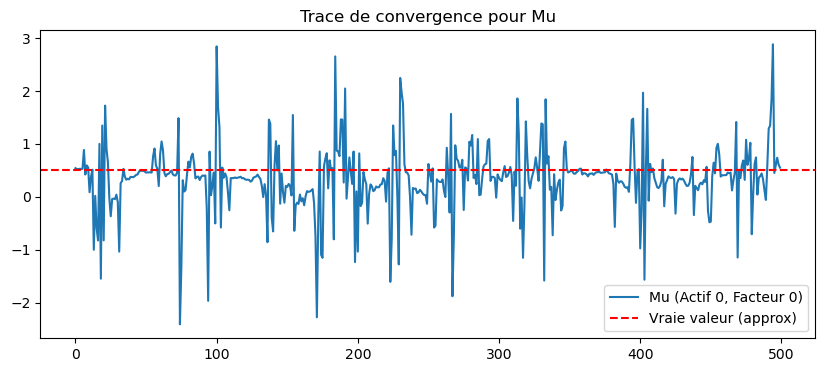

In [ ]:
# 1. Paramètres
T_sim = 1000
n_sim = 20  # 20 actifs
p_sim = 1  # 1 facteur
N_ITER = 500 # Nombre d'itérations MCMC

# 2. Données
data = simulate_data(T_sim, n_sim, p_sim)

# 3. Instanciation du Sampler
sampler = FactorCopulaSampler(data, p_sim)

# 4. Préparation du stockage (Trace)
# On stocke l'historique de mu pour visualiser la convergence par exemple
# Vous pouvez faire de même pour phi et sigma
trace_mu = np.zeros((N_ITER, n_sim, p_sim))

# 5. Boucle Principale
print("Démarrage du Gibbs Sampler...")
for it in tqdm(range(N_ITER)):
    
    # A. Mises à jour séquentielles
    # On appelle explicitement chaque étape dans l'ordre
    sampler.update_rho()
    sampler.update_z()# Step 4
    sampler.update_lambda_pg_parallel()  # Step 5
    sampler.update_sigma()      # Step 6
    sampler.update_mu_phi()     # Step 7
    
    # B. Stockage
    # On sauvegarde une copie profonde des paramètres à chaque itération
    trace_mu[it] = sampler.theta['mu'].copy()

print("Terminé !")

# 6. Visualisation rapide
plt.figure(figsize=(10, 4))
plt.plot(trace_mu[:, 0, 0], label="Mu (Actif 0, Facteur 0)")
plt.axhline(0.5, color='r', linestyle='--', label="Vraie valeur (approx)")
plt.title("Trace de convergence pour Mu")
plt.legend()
plt.show()

In [13]:
trace_mu[100]

array([[ 2.84192165],
       [ 0.69476971],
       [ 0.42811788],
       [ 0.20507403],
       [ 1.2906083 ],
       [ 2.42538451],
       [ 0.58635813],
       [ 0.31577711],
       [ 0.19189611],
       [ 0.30284943],
       [ 0.37498707],
       [-0.08962239],
       [ 0.08089729],
       [-2.42180354],
       [ 0.32533063],
       [ 0.46365052],
       [ 0.56112491],
       [-0.98892188],
       [-1.35072745],
       [-1.05784441]])